In [3]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import copy
import math
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from aux import *
from visualize import *
from model_log import *

In [4]:
DATA_PATH = '../Data/'
class_ids = sorted([int(file_name.split('_')[0]) for file_name in os.listdir(DATA_PATH) if file_name.endswith('sex.csv')])

# networks and affective matrices of all classes in wave 1 and wave 2
train_networks = {}
train_affectives = {}
networks_to_simulate = {}
affective_to_simulate = {}

for class_id in class_ids:
    train_networks[class_id] = load_data(class_id, 1)
    train_affectives[class_id] = pd.read_csv(DATA_PATH + str(class_id) + '_affective_w1.csv', \
                                            header = 0, index_col = 0)
    networks_to_simulate[class_id] = load_data(class_id, 2)
    affective_to_simulate[class_id] = pd.read_csv(DATA_PATH + str(class_id) + '_affective_w2.csv', \
                                      header = 0, index_col = 0)

In [5]:
# Game Structure
PAYOFF_FUNCTION = {('tell a secret', 'tell a secret'): (1, 1),
                   ('tell a secret', 'restrain'): (-1, 0),
                   ('restrain', 'tell a secret'): (0, -1),
                   ('restrain', 'restrain'): (0, 0)}

In [6]:
### Simulation by using logistic regression

In [49]:
# Set parameters
NUM_STEP = 6
corr_friend_trust = 0.6395

In [54]:
# Prepare for simulation
simulated_networks = {}

for class_id in [1100]:
    train_network = train_networks[class_id]
    train_affective = train_affectives[class_id]
    trust_network = networks_to_simulate[class_id]
    affective_matrix = affective_to_simulate[class_id]
    
    model = TrustModel(train_network, train_affective, trust_network, affective_matrix, corr_friend_trust)
    simulated_networks[class_id] = model.run(NUM_STEP)

strategy                            a_prob_coop b_prob_coop a trusts b   b trusts a   affective(a,b)  affective(b,a) 
('restrain', 'restrain')            0.027      0.005      False        False        0.0             -1.0           
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('restrain', 'restrain')            0.011      0.011      False       

('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('restrain', 'restrain')            0.058      0.058      False        False        1.0             1.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.005      0.027      False        False        -1.0            0.0            
('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('restrain', 'restrain')            0.007      0.007      False        F

('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.058      0.002      False        False        1.0             -1.0           
('restrain', 'restrain')            0.058      0.058      False        False        1.0             1.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.058      0.0        False        False        1.0             -2.0           
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.027      0.005      False        False        0.0             -1.0           
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         T

('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.011      0.002      False        False        0.0             -1.0           
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('restrain', 'restrain')            0.027      0.001      False        False        0.0             -2.0           
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.011      0.011      False        F

('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('restrain', 'restrain')            0.039      0.039      False        False        1.0             1.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('restrain', 'restrain')            0.027      0.027      False        False        0.0             0.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         True         2               2              
('restrain', 'restrain')            0.011      0.011      False        False        0.0             0.0            
('tell a secret', 'tell a secret')  0.472      0.472      True         T

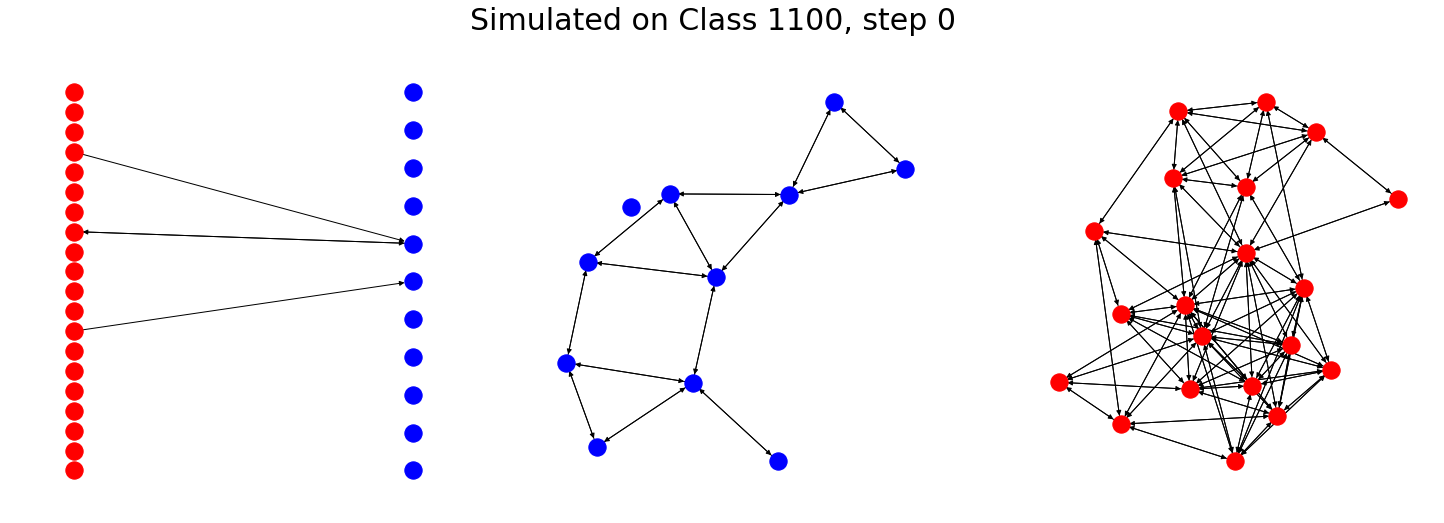

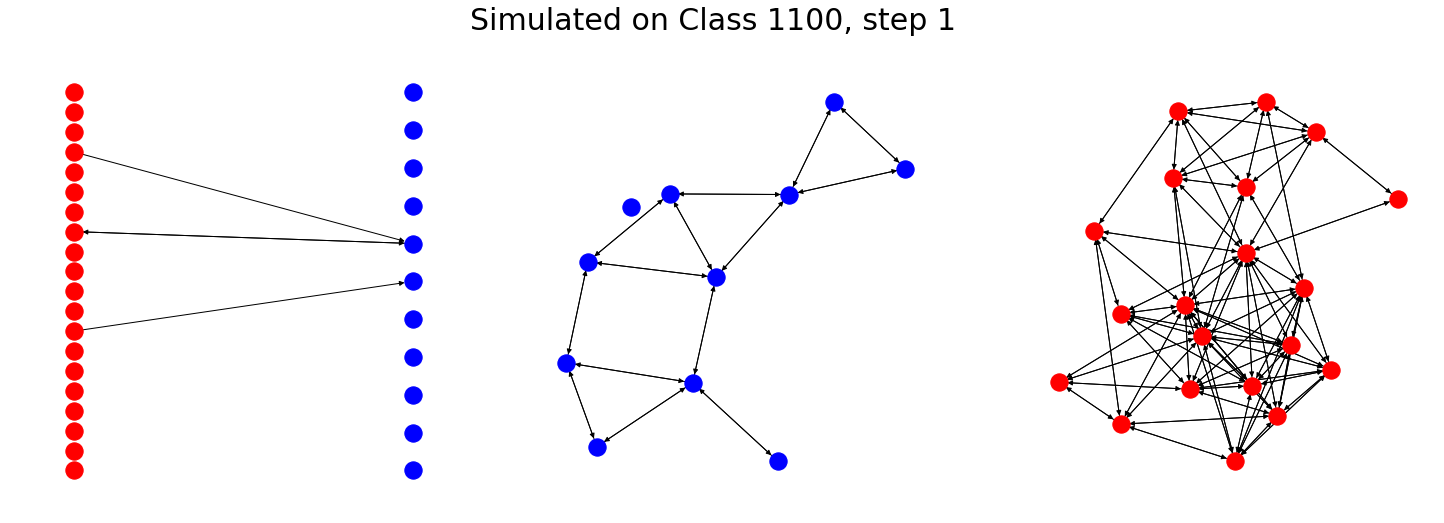

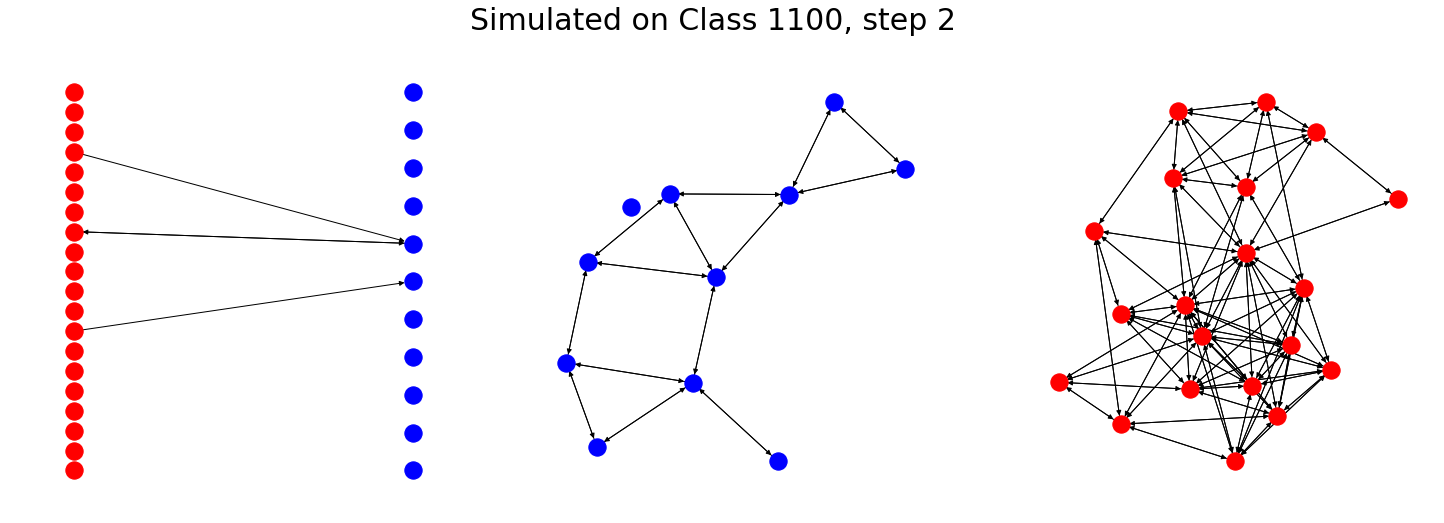

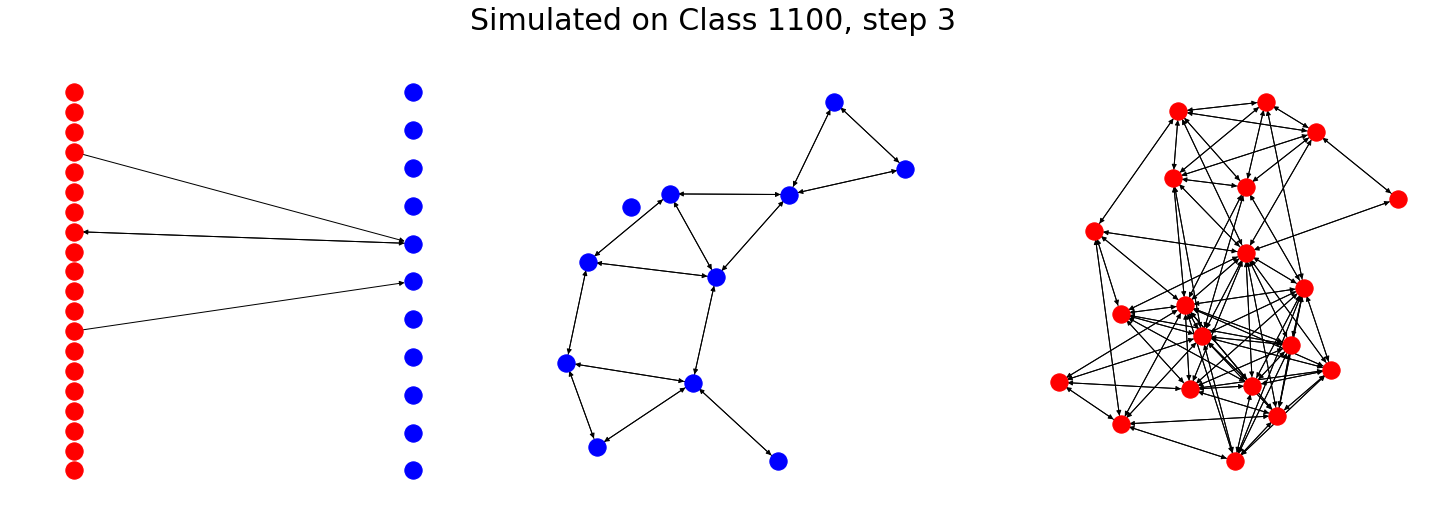

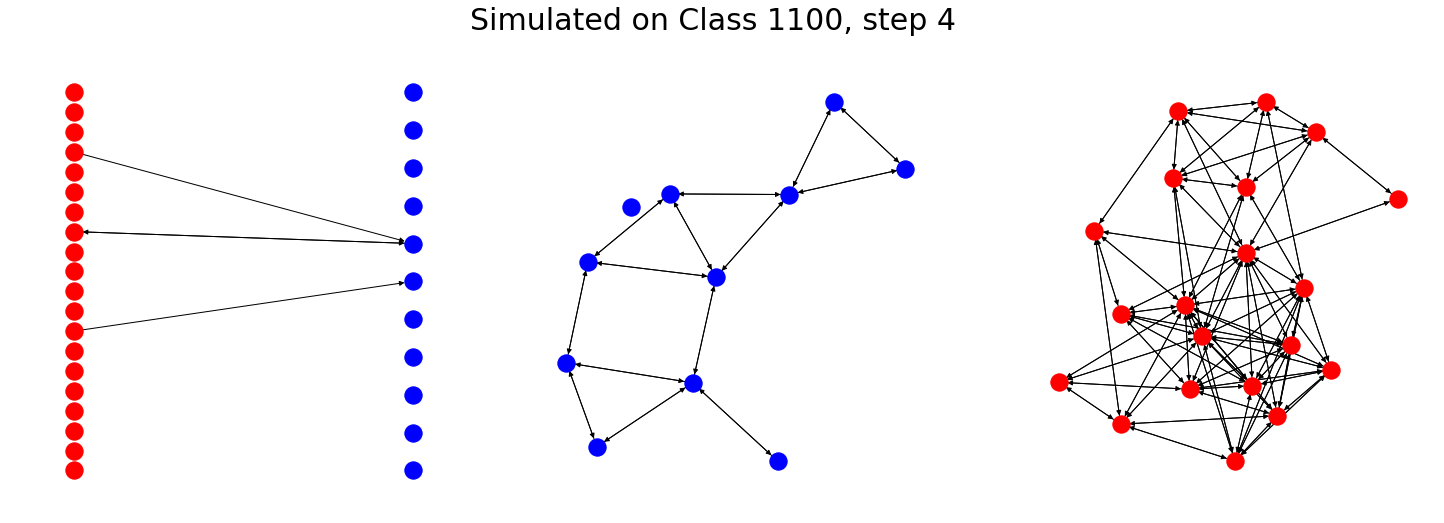

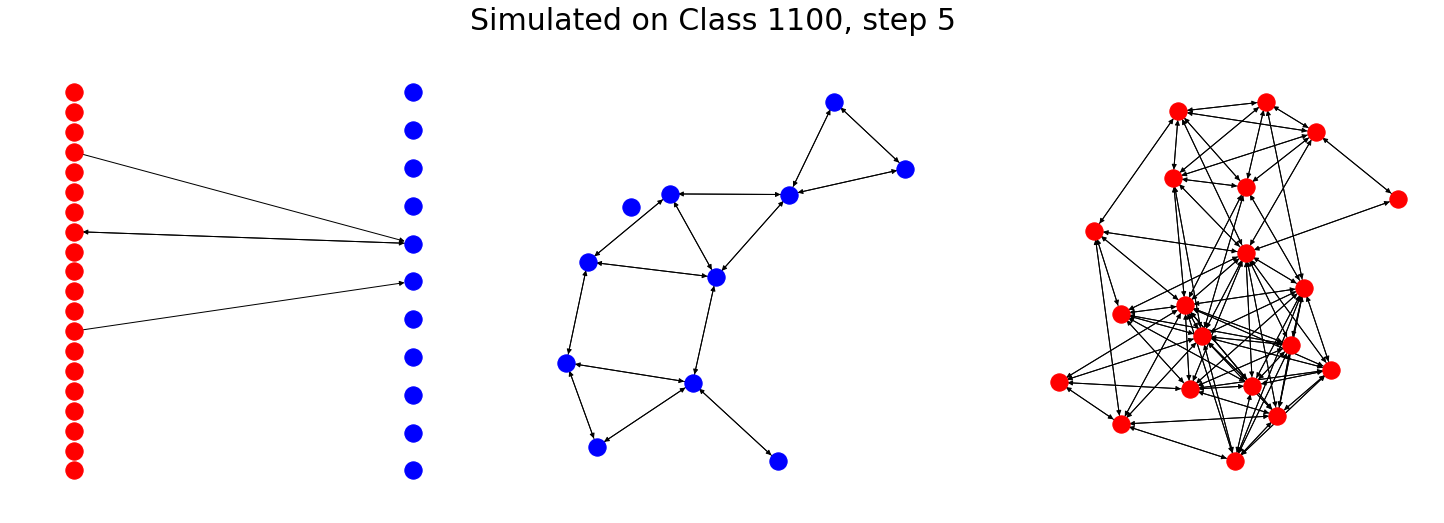

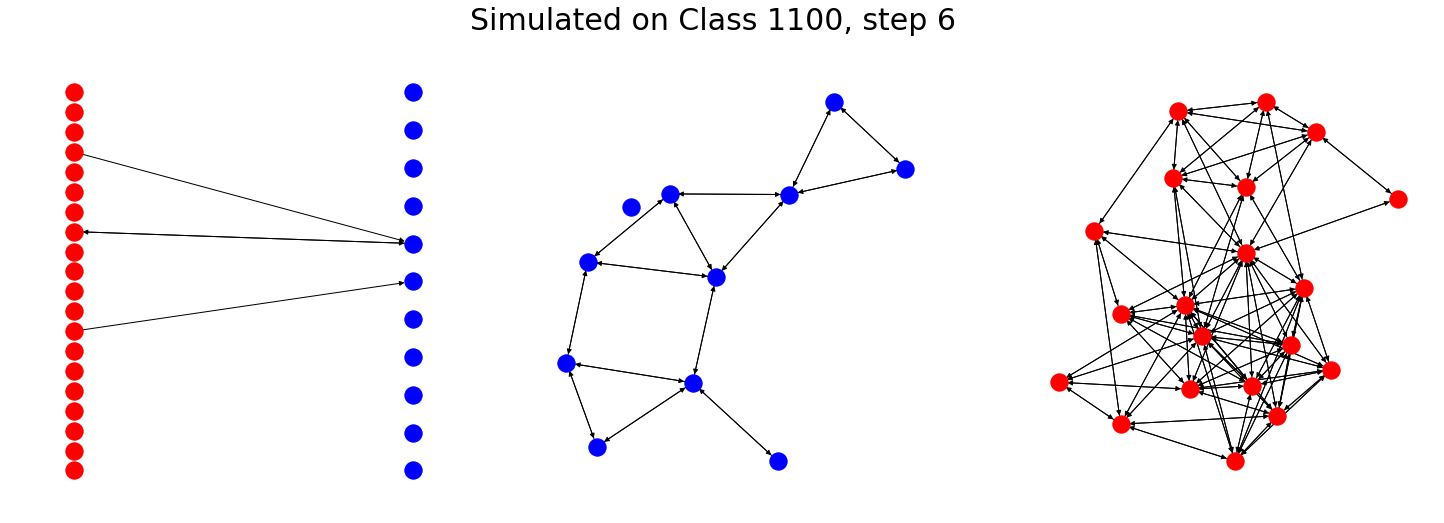

In [51]:
# Visualize a class in all steps
SELECTED_CLASS = 1100
for step in range(NUM_STEP + 1):
    visualize(simulated_networks[1100][step], SELECTED_CLASS, step)

KeyError: 1200

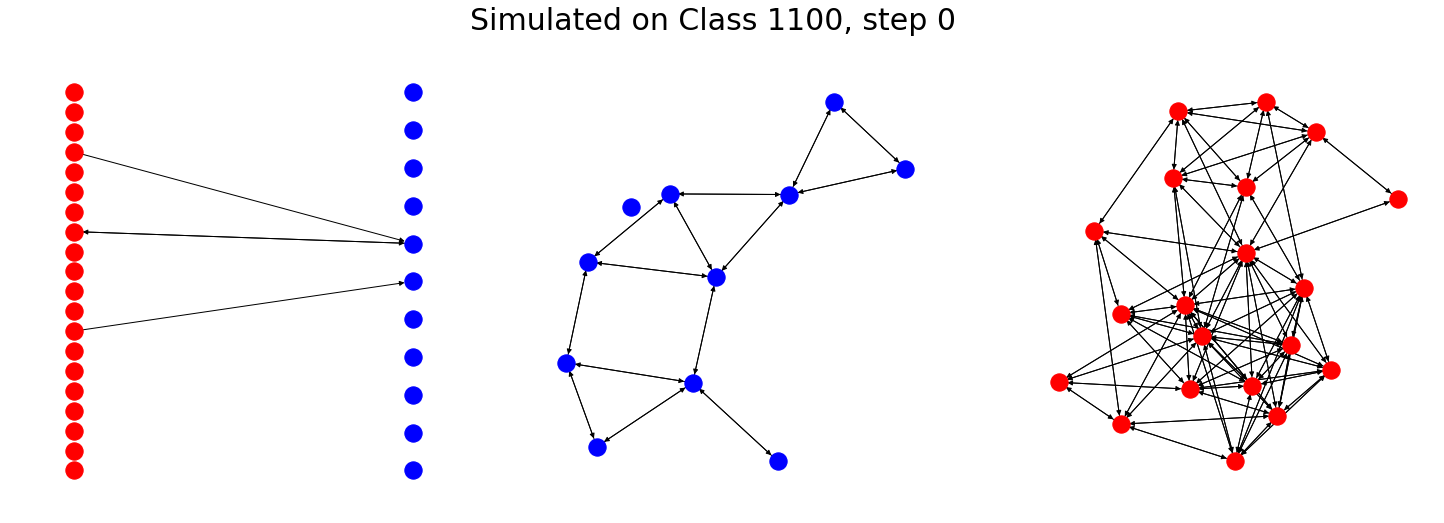

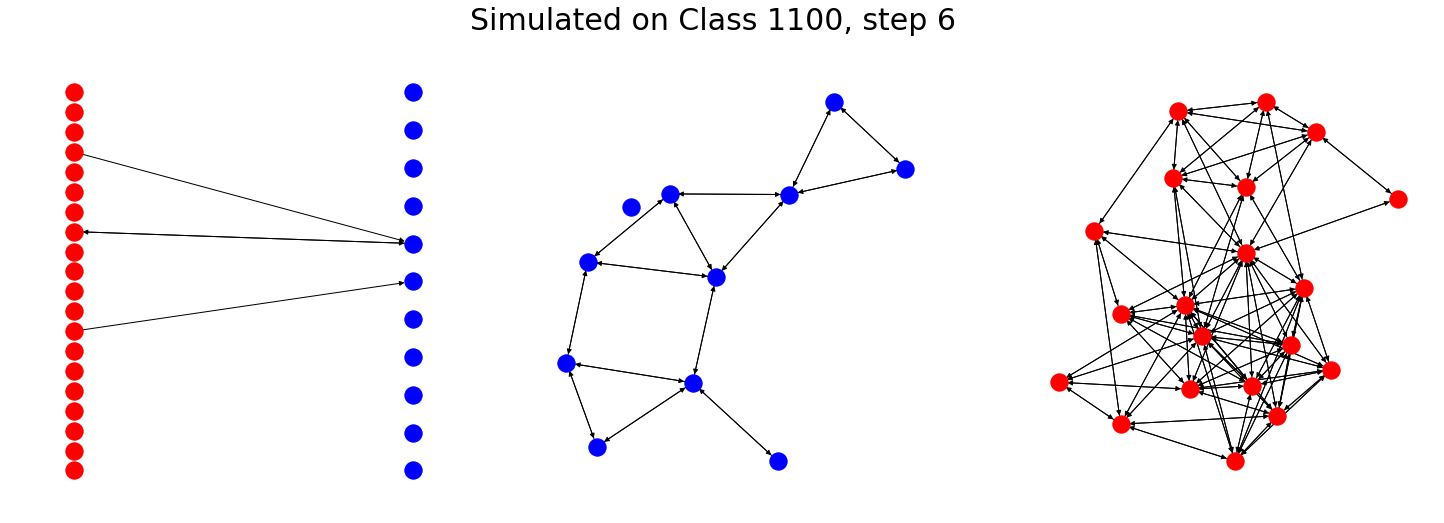

In [52]:
# Visualize all classes in step 0 and step #NUM_STEP
for class_id in class_ids:
    visualize(simulated_networks[class_id][0], class_id, 0)
    visualize(simulated_networks[class_id][NUM_STEP], class_id, NUM_STEP)

In [23]:
def plot_assortativity(networks):
    """
    Draw scatter plots of assortativity of step 0 and step 6
    """
    
    params = ['f2f', 'm2m', 'f2m', 'm2f']
    
    for param in params:
        x = []
        y = []
        for class_id in class_ids:
            f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][0])
            x.append(eval(param))
            f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][-1])
            y.append(eval(param))
            
        xymax = max(max(x), max(y)) + 0.05
        plt.xlim((-0.05, xymax))
        plt.ylim((-0.05, xymax))
        plt.suptitle('assortativity {}'.format(param), fontsize = 20)
        plt.scatter(x, y)
        plt.xlabel('Step 0')
        plt.ylabel('Step 6')
        
        # Calculate Pearson Correlation Coefficient
        corr = np.corrcoef(np.vstack([np.array(x), np.array(y)]))
        corr = round(corr[0][1], 2)
        
        # Linear Regression
        coef, error, _, _, _ = np.polyfit(x, y, 1, full = True)
        error = round(error[0], 2)
        sns.regplot(x, y, color='b', scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ci=95)
        
        # Hard coding here, sad
        if param == 'f2f':
            plt.text(0.5, 0.4 * coef[0] + coef[1] - 0.2, \
            'slope = {} \n error = {} \n corr = {}'.format(round(coef[0], 2), error, corr))
        else:
            plt.text(xymax/2 + 0.02, xymax/2 * coef[0] + coef[1] - 0.12, \
            'slope = {} \n error = {} \n corr = {}'.format(round(coef[0], 2), error, corr))
        
        plt.savefig('assortativity{}.png'.format(param), dpi = 300)
        plt.show()

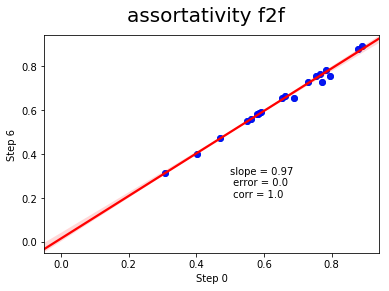

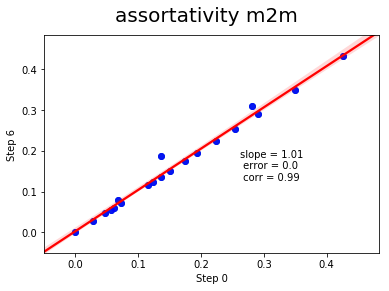

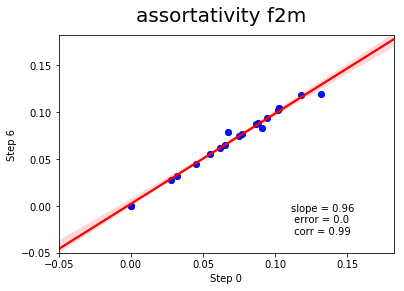

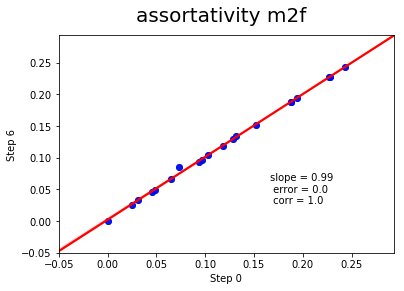

In [24]:
plot_assortativity(simulated_networks)

In [25]:
def get_parameters(networks):
    """
    Generate the csv file that records parameters of the simulated networks in step 6 for each class
    """
    
    df = pd.DataFrame(np.nan, index=class_ids, columns=['attribute', 'f2f', 'm2m', 'f2m', 'm2f', 'density'])

    for class_id in class_ids:
        f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][-1])
        df.at[class_id, 'f2f'] = f2f
        df.at[class_id, 'm2m'] = m2m
        df.at[class_id, 'f2m'] = f2m
        df.at[class_id, 'm2f'] = m2f
        
        attribute_assortativity = nx.attribute_assortativity_coefficient(networks[class_id][-1], 'sex')
        attribute_assortativity = round(attribute_assortativity, 3)
        df.at[class_id, 'attribute'] =  attribute_assortativity
        
        density = nx.density(networks[class_id][-1])
        density = round(density, 3)
        df.at[class_id, 'density'] = density
        
    print(df)
    df.to_csv('params for step 6.csv', sep=',')
    

In [26]:
get_parameters(simulated_networks)

      attribute    f2f    m2m    f2m    m2f  density
1100      0.766  0.729  0.188  0.083  0.000    0.052
1200      0.499  0.729  0.115  0.062  0.094    0.086
1300      0.391  0.757  0.079  0.079  0.086    0.118
1500      0.690  0.890  0.061  0.000  0.049    0.117
2100     -0.061  0.877  0.000  0.077  0.046    0.128
2200      0.237  0.561  0.123  0.088  0.228    0.088
2400      0.340  0.591  0.136  0.045  0.227    0.031
2800      0.493  0.583  0.194  0.028  0.194    0.044
3100      0.426  0.587  0.174  0.087  0.152    0.057
3200      0.095  0.764  0.028  0.104  0.104    0.094
3400      0.485  0.313  0.433  0.119  0.134    0.056
4100      0.922  0.655  0.310  0.000  0.034    0.107
4200      0.310  0.401  0.254  0.102  0.243    0.149
4300      0.352  0.471  0.224  0.118  0.188    0.080
4400      0.261  0.781  0.048  0.105  0.067    0.079
5400      0.719  0.581  0.290  0.032  0.097    0.029
6100      0.359  0.755  0.073  0.055  0.118    0.104
6200      0.482  0.655  0.151  0.065  0.129   